# MNIST CNN 

The goal of this notebook is to show images as Datas, hence justifies the introduction of NoSQL dbs, to store and treat them as Datas. 

## Load images

In [1]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt 

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


## Visualize them

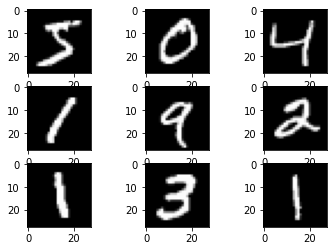

In [2]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Deep Learning CNN From Scratch

## Libraries

In [3]:
# save the final model to file
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

## Functions

In [4]:
# load train and test dataset
def load_dataset():
    
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    
    # one hot encode target values
    trainY = to_categorical(trainY)    # 3 --> [0,0,0,1,0,0,0,0,0,0]
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

In [5]:
# scale pixels -- Mnist is made of integer between 0 and 255 in greyscale
# we want them better, to find their best characteristic
def prep_pixels(train, test):
    
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    # return normalized images
    return train_norm, test_norm

## Model Definition

In [6]:
# define cnn model using Keras
def define_model(two_layers=True):
    if two_layers:
        # First initialize it
        model = Sequential()
        # Adding layers
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(10, activation='softmax'))
    else:
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(10, activation='softmax'))
    # compile the result
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main Code

## Data Pre-Processing

In [7]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

## Convnet Creation and Training

In [8]:
# define model
model = define_model()
# evaluate model on test dataset

print('Pre Training \n')    

err, acc = model.evaluate(testX, testY, verbose=1)
print('Starting Accuracy \t> %.3f' % (acc * 100.0))

print('\nTRAINING\n')  

# fit model
model.fit(trainX, trainY, epochs=4, batch_size=32, verbose=1, workers=2)
 
print('\n\nPost Training \n')    

# evaluate model on test dataset
err, acc = model.evaluate(testX, testY, verbose=1)
    
print('Final Accuracy %.3f' % (acc * 100.0))

# save model
model.save('convnet_mnist_twolayers.h5')

Pre Training 

313/313 [==============================] - 1s 5ms/step - loss: 2.6936 - accuracy: 0.1168
Starting Accuracy 	> 11.680

TRAINING

Epoch 1/4
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1204 - accuracy: 0.9629
Epoch 2/4
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0420 - accuracy: 0.9870
Epoch 3/4
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0282 - accuracy: 0.9909
Epoch 4/4
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0192 - accuracy: 0.9938


Post Training 

313/313 [==============================] - 2s 5ms/step - loss: 0.0321 - accuracy: 0.9891
Final Accuracy 98.910


## Convnet Reloading
> In case we need directly the convnet we don't need to retrain the model, but simply load the already trained one.

### Reload Db and its preparation

In [9]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

### Reload Model Convnet

In [10]:
# load model
model = load_model('final_model.h5')

print('\n\nCheck Model \n')    

# evaluate model on test dataset
err, acc = model.evaluate(testX, testY, verbose=1)
    
print('Final Accuracy %.3f' % (acc * 100.0))



Check Model 

313/313 [==============================] - 2s 5ms/step - loss: 0.0307 - accuracy: 0.9904
Final Accuracy 99.040


## Confusion Matrix

It's a tool we use to understand how well our model behaves. 

I put the results in a df so it's easier to see.

### Result Confusion Matrix

In [40]:
y_pred = model.predict(testX)
matrix = confusion_matrix(testY.argmax(axis=1), y_pred.argmax(axis=1))
# I need the total counts of each digits
total = np.zeros(10)
for i in testY:
    total[i.argmax()] += 1
results_confusion = pd.DataFrame(matrix)
total_element_by_number = total

In [41]:
results_confusion

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,1,1,1,0
1,0,1128,1,1,2,1,2,0,0,0
2,0,0,1024,0,1,0,1,4,2,0
3,0,0,1,1007,0,1,0,0,1,0
4,0,0,0,0,975,0,3,0,0,4
5,2,0,0,7,0,879,2,0,0,2
6,6,2,0,0,1,2,947,0,0,0
7,0,2,6,3,1,1,0,1007,1,7
8,4,0,4,3,0,2,0,0,957,4
9,1,0,0,0,3,1,0,0,1,1003


### Percentage Confusion Matrix

In [42]:
print(total_element_by_number)

[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [43]:
# I take the percentage
total /= 100. # I have all this elements
matrix = matrix.astype('float32')
for i in range(0,10):
    matrix[i,:] /= total[i]
ConfusionMatrix = pd.DataFrame(matrix)
for i in range(10):
    ConfusionMatrix[i] = ConfusionMatrix[i].apply(lambda x:np.round(x,3))

In [44]:
ConfusionMatrix.head(10)

,0,1,2,3,4,5,6,7,8,9
0,99.694,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.000
1,0.000,99.383,0.088,0.088,0.176,0.088,0.176,0.000,0.000,0.000
2,0.000,0.000,99.225,0.000,0.097,0.000,0.097,0.388,0.194,0.000
3,0.000,0.000,0.099,99.703,0.000,0.099,0.000,0.000,0.099,0.000
4,0.000,0.000,0.000,0.000,99.287,0.000,0.305,0.000,0.000,0.407
5,0.224,0.000,0.000,0.785,0.000,98.543,0.224,0.000,0.000,0.224
6,0.626,0.209,0.000,0.000,0.104,0.209,98.852,0.000,0.000,0.000
7,0.000,0.195,0.584,0.292,0.097,0.097,0.000,97.957,0.097,0.681
8,0.411,0.000,0.411,0.308,0.000,0.205,0.000,0.000,98.255,0.411
9,0.099,0.000,0.000,0.000,0.297,0.099,0.000,0.000,0.099,99.405


## Total Accuracy

In [45]:
# For Each Number
for i in range(10):
    print(i, end=" -- ")
    print(np.diag(ConfusionMatrix)[i])

0 -- 99.694
1 -- 99.383
2 -- 99.225
3 -- 99.703
4 -- 99.287
5 -- 98.543
6 -- 98.852
7 -- 97.957
8 -- 98.255
9 -- 99.405


In [46]:
# on the db
print(np.average(np.diag(ConfusionMatrix)))

99.0304


## Better Confusion Matrix

Here we present a different version of Confusion Matrix

[ 9.8  11.35 10.32 10.1   9.82  8.92  9.58 10.28  9.74 10.09]


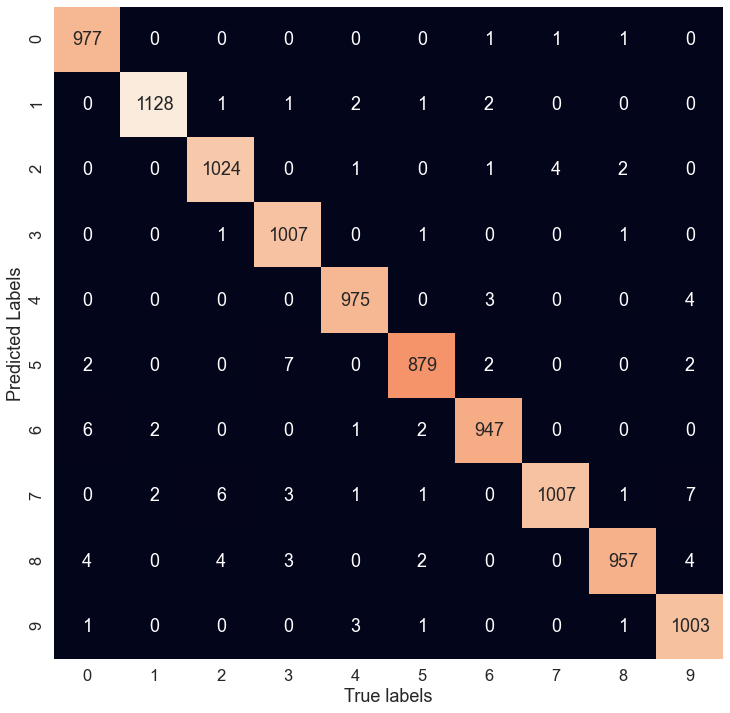

In [47]:
import seaborn as sns

sns.set(font_scale=1.5)

y_preds = model.predict(testX).argmax(axis=1)
y_test = testY.argmax(axis=1)



def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's Heatmap()
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), 
                     annot=True, 
                     cbar=False, 
                     fmt='g')
    plt.xlabel("True labels")
    plt.ylabel("Predicted Labels")
    
plot_conf_mat(y_test, y_preds)

print(total_element_by_number)